In [1]:
import torch 
import numpy as np

/Users/sangje/miniforge3/envs/sslsv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pytorch_lightning import LightningModule, Trainer, seed_everything

# Pytorch Lightning 을 사용하여 Framework 구성하기

- 1. Task(Model) 
- 2. DataModule
- 3. Trainer

## 여기에 Customizing 으로 정교화.

In [3]:
class Task(LightningModule):
    def __init__(
        self,
        learning_rate: float = 0.01,
        **kwargs
    ):
        super().__init__()
        self.melspectogram = MelSpectrogram()
        self.encoder = None
        self.projector = None
        
    def forward(self,x):
        features = self.melspectogram(x)
        embeddings = self.encoder(features)
        outputs = self.projector(embeddings)
        return outputs
        
    def trainig_step(self, batch, batch_idx):
        waveform, label = batch
        features = self.melspectogram(waveform)
        embeddings = self.encoder(features)
        outputs = self.projector(embeddings)
        
        loss, acc = self.loss_fun(outputs, label)
        self.log('train_loss', loss, prog_bar = True)
        self.log('acc', acc, prog_bar = True)        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )
        scheduler = StepLR(optimizer, step_size=self.hparams.step_size, gamma=self.hparams.gamma)
        return [optimizer], [scheduler]

    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx,
                       optimizer_closure, on_tpu, using_native_amp, using_lbfgs):
        # warm up learning_rate
        if self.trainer.global_step < self.hparams.warmup_step:
            lr_scale = min(1., float(self.trainer.global_step +
                           1) / float(self.hparams.warmup_step))
            for idx, pg in enumerate(optimizer.param_groups):
                pg['lr'] = lr_scale * self.hparams.learning_rate
        # update params
        optimizer.step(closure=optimizer_closure)
        optimizer.zero_grad()

In [9]:
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F

class PreEmphasis(torch.nn.Module):
    def __init__(self, coef: float = 0.97):
        super(PreEmphasis, self).__init__()
        self.coef = coef
        # make kernel
        # In pytorch, the convolution operation uses cross-correlation. So, filter is flipped.
        self.register_buffer(
            'flipped_filter', torch.FloatTensor(
                [-self.coef, 1.]).unsqueeze(0).unsqueeze(0)
        )

    def forward(self, inputs: torch.tensor) -> torch.tensor:
        assert len(
            inputs.size()) == 2, 'The number of dimensions of inputs tensor must be 2!'
        # reflect padding to match lengths of in/out
        inputs = inputs.unsqueeze(1)
        inputs = F.pad(inputs, (1, 0), 'reflect')
        return F.conv1d(inputs, self.flipped_filter).squeeze(1)
    
class Mel_Spectrogram(nn.Module):
    def __init__(self, sample_rate=16000, n_fft=512, win_length=400, hop=160, n_mels=80, coef=0.97, requires_grad=False):
        super(Mel_Spectrogram, self).__init__()
        self.n_fft = n_fft
        self.n_mels = n_mels
        self.win_length = win_length
        self.hop = hop

        self.pre_emphasis = PreEmphasis(coef)
        mel_basis = librosa.filters.mel(
            sr=sample_rate, n_fft=n_fft, n_mels=n_mels)
        self.mel_basis = nn.Parameter(
            torch.FloatTensor(mel_basis), requires_grad=requires_grad)
        self.instance_norm = nn.InstanceNorm1d(num_features=n_mels)
        window = torch.hamming_window(self.win_length)
        self.window = nn.Parameter(
            torch.FloatTensor(window), requires_grad=False)

    def forward(self, x):
        x = self.pre_emphasis(x)
        x = torch.stft(x, n_fft=self.n_fft, hop_length=self.hop,
                       window=self.window, win_length=self.win_length, return_complex=True)
        x = torch.abs(x)
        x += 1e-9
        x = torch.log(x)
        x = torch.matmul(self.mel_basis, x)
        x = self.instance_norm(x)
        x = x.unsqueeze(1)
        return x

In [10]:
melspec=Mel_Spectrogram()

In [38]:
audio = librosa.load('sample.wav',dtype='float32')

In [77]:
transformed_wave=melspec(torch.Tensor(audio[0]).unsqueeze(0)).squeeze(0).squeeze(0)

In [87]:
transformed_wave.shape

torch.Size([80, 414])

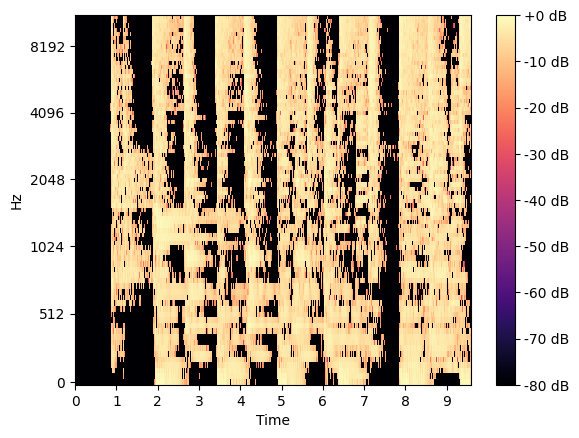

In [90]:
import librosa.display
import matplotlib.pyplot as plt

S_DB = librosa.power_to_db(transformed_wave, ref=np.max)
librosa.display.specshow(S_DB, sr=22050, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

In [ ]:
import os
from typing import Any, Callable, Optional

import numpy as np
import torch
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader


class SPK_datamodule(LightningDataModule):
    def __init__(
        self,
        train_csv_path,
        trial_path,
        unlabel_csv_path = None,
        second: int = 2,
        num_workers: int = 16,
        batch_size: int = 32,
        shuffle: bool = True,
        pin_memory: bool = True,
        drop_last: bool = True,
        pairs: bool = True,
        aug: bool = False,
        semi: bool = False,
        *args: Any,
        **kwargs: Any,
    ) -> None:
        super().__init__(*args, **kwargs)

        self.train_csv_path = train_csv_path
        self.unlabel_csv_path = unlabel_csv_path
        self.second = second
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.trial_path = trial_path
        self.pairs = pairs
        self.aug = aug
        print("second is {:.2f}".format(second))

    def train_dataloader(self) -> DataLoader:
        if self.unlabel_csv_path is None:
            train_dataset = Train_Dataset(self.train_csv_path, self.second, self.pairs, self.aug)
        else:
            train_dataset = Semi_Dataset(self.train_csv_path, self.unlabel_csv_path, self.second, self.pairs, self.aug)
        loader = torch.utils.data.DataLoader(
                train_dataset,
                shuffle=True,
                num_workers=self.num_workers,
                batch_size=self.batch_size,
                pin_memory=True,
                drop_last=False,
                )
        return loader

    def val_dataloader(self) -> DataLoader:
        trials = np.loadtxt(self.trial_path, str)
        self.trials = trials
        eval_path = np.unique(np.concatenate((trials.T[1], trials.T[2])))
        print("number of enroll: {}".format(len(set(trials.T[1]))))
        print("number of test: {}".format(len(set(trials.T[2]))))
        print("number of evaluation: {}".format(len(eval_path)))
        eval_dataset = Evaluation_Dataset(eval_path, second=-1)
        loader = torch.utils.data.DataLoader(eval_dataset,
                                             num_workers=10,
                                             shuffle=False, 
                                             batch_size=1)
        return loader

    def test_dataloader(self) -> DataLoader:
        return self.val_dataloader()

In [98]:
from scipy.io import wavfile
sample_rate,wave = wavfile.read('sample.wav')

In [106]:
audio_length = wave.shape[0]

In [108]:
length = np.int64(sample_rate * 2)

In [109]:
shortage = length - audio_length

In [113]:
waveform = np.pad(wave, (0, abs(shortage)), 'wrap')

In [114]:
print(wave.shape,waveform.shape)

(66150,) (88200,)


In [120]:
for idx in waveform:
    print(idx)

3
7
0
5
7
4
3
7
5
5
2
3
-1
0
4
2
-2
-1
1
1
1
-2
-2
1
2
-4
-4
0
-2
-3
-2
-1
-3
-6
-7
-5
-3
-3
-5
-4
-8
-5
-9
-8
-8
-6
-9
-11
-13
-11
-12
-11
-12
-12
-10
-11
-13
-14
-9
-13
-9
-9
-12
-16
-14
-19
-15
-16
-13
-16
-15
-16
-16
-14
-14
-17
-18
-14
-15
-21
-19
-15
-19
-18
-20
-17
-19
-19
-22
-19
-19
-21
-22
-23
-20
-23
-22
-27
-21
-22
-23
-24
-26
-26
-25
-22
-25
-22
-27
-23
-24
-24
-26
-25
-22
-24
-24
-21
-24
-23
-23
-24
-21
-23
-24
-23
-22
-24
-23
-25
-22
-21
-23
-22
-23
-23
-22
-21
-22
-20
-22
-20
-22
-21
-18
-21
-18
-20
-18
-19
-17
-21
-20
-17
-17
-16
-16
-14
-17
-14
-12
-11
-12
-14
-13
-13
-13
-12
-9
-13
-8
-12
-11
-10
-12
-12
-7
-9
-8
-7
-10
-11
-8
-9
-9
-7
-10
-9
-12
-11
-10
-10
-6
-7
-10
-10
-8
-9
-8
-9
-9
-8
-8
-11
-12
-10
-14
-10
-13
-14
-11
-15
-17
-15
-9
-11
-11
-9
-13
-13
-13
-11
-13
-12
-11
-14
-14
-16
-13
-16
-14
-12
-15
-16
-13
-15
-15
-15
-11
-16
-17
-15
-16
-17
-16
-15
-16
-13
-17
-16
-17
-18
-18
-17
-16
-13
-17
-18
-17
-17
-15
-16
-14
-13
-18
-17
-18
-18
-18
-15
-16
-16
-12
-

In [133]:
import random
np.int64(random.random()*(audio_length-length))

16259

In [158]:
waveform.astype(np.float64)

array([   3.,    7.,    0., ..., -366., -324., -218.])

In [149]:
arr=waveform/10

In [152]:
type(arr[0])

numpy.float64

In [161]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from scipy.io import wavfile
from scipy import signal
import soundfile

def compute_dB(waveform):
    """
    Args:
        x (numpy.array): Input waveform (#length).
    Returns:
        numpy.array: Output array (#length).
    """
    val = max(0.0, np.mean(np.power(waveform, 2)))
    dB = 10*np.log10(val+1e-4)
    return dB

class WavAugment(object):
    def __init__(self, noise_csv_path="data/noise.csv", rir_csv_path="data/rir.csv"):
        self.noise_paths = pd.read_csv(noise_csv_path)["utt_paths"].values
        self.noise_names = pd.read_csv(noise_csv_path)["speaker_name"].values
        self.rir_paths = pd.read_csv(rir_csv_path)["utt_paths"].values

    def __call__(self, waveform):
        idx = np.random.randint(0, 10)
        if idx == 0:
            waveform = self.add_gaussian_noise(waveform)
            waveform = self.add_real_noise(waveform)

        if idx == 1 or idx == 2 or idx == 3:
            waveform = self.add_real_noise(waveform)

        if idx == 4 or idx == 5 or idx == 6:
            waveform = self.reverberate(waveform)

        if idx == 7:
            waveform = self.change_volum(waveform)
            waveform = self.reverberate(waveform)

        if idx == 6:
            waveform = self.change_volum(waveform)
            waveform = self.add_real_noise(waveform)

        if idx == 8:
            waveform = self.add_gaussian_noise(waveform)
            waveform = self.reverberate(waveform)

        return waveform

    def add_gaussian_noise(self, waveform):
        """
        Args:
            x (numpy.array): Input waveform array (#length).
        Returns:
            numpy.array: Output waveform array (#length).
        """
        snr = np.random.uniform(low=10, high=25)
        clean_dB = compute_dB(waveform)
        noise = np.random.randn(len(waveform))
        noise_dB = compute_dB(noise)
        noise = np.sqrt(10 ** ((clean_dB - noise_dB - snr) / 10)) * noise
        waveform = (waveform + noise)
        return waveform

    def change_volum(self, waveform):
        """
        Args:
            x (numpy.array): Input waveform array (#length).
        Returns:
            numpy.array: Output waveform array (#length).
        """
        volum = np.random.uniform(low=0.8, high=1.0005)
        waveform = waveform * volum
        return waveform

    def add_real_noise(self, waveform):
        """
        Args:
            x (numpy.array): Input length (#length).
        Returns:
            numpy.array: Output waveform array (#length).
        """
        clean_dB = compute_dB(waveform)

        idx = np.random.randint(0, len(self.noise_paths))
        sample_rate, noise = wavfile.read(self.noise_paths[idx])
        noise = noise.astype(np.float64)

        snr = np.random.uniform(15, 25)

        noise_length = len(noise)
        audio_length = len(waveform)

        if audio_length >= noise_length:
            shortage = audio_length - noise_length
            noise = np.pad(noise, (0, shortage), 'wrap')
        else:
            start = np.random.randint(0, (noise_length-audio_length))
            noise = noise[start:start+audio_length]

        noise_dB = compute_dB(noise)
        noise = np.sqrt(10 ** ((clean_dB - noise_dB - snr) / 10)) * noise
        waveform = (waveform + noise)
        return waveform

    def reverberate(self, waveform):
        """
        Args:
            x (numpy.array): Input length (#length).
        Returns:
            numpy.array: Output waveform array (#length).
        """
        audio_length = len(waveform)
        idx = np.random.randint(0, len(self.rir_paths))

        path = self.rir_paths[idx]
        rir, sample_rate = soundfile.read(path)
        rir = rir/np.sqrt(np.sum(rir**2))

        waveform = signal.convolve(waveform, rir, mode='full')
        return waveform[:audio_length]

In [2]:
import collections
import os
import random

import numpy as np
import pandas as pd
import torch
from scipy import signal
from scipy.io import wavfile
from sklearn.utils import shuffle
from torch.utils.data import DataLoader, Dataset

# Second를 인자로 받아서 Audio 가 짧으면 Padding, 길면 Cut 
def load_audio(filename, second=2):
    sample_rate, waveform = wavfile.read(filename)
    audio_length = waveform.shape[0]

    if second <= 0:
        return waveform.astype(np.float64).copy()

    length = np.int64(sample_rate * second)

    if audio_length <= length:
        shortage = length - audio_length
        waveform = np.pad(waveform, (0, shortage), 'wrap')
        waveform = waveform.astype(np.float64)
    else:
        start = np.int64(random.random()*(audio_length-length))
        waveform =  waveform[start:start+length].astype(np.float64)
    return waveform.copy()

In [9]:
wave=load_audio("sample.wav",second=2)

In [15]:
torch.FloatTensor(wave).requires_grad

False